# Reproducing Jamie's analysis and testing  figures

Some of the code below was written by Jamie Griffith.  I am testing that here.  

I am also using this notebook as a testing ground for figures that could be included in the dashboard.

In [1]:
library(lurn)
library(ggplot2)
library(GGally)
library(gt)
library(ggradar)
library(viridis)
library(dplyr)
library(tidyr)
library(cowplot)
library(gridExtra)
library(magick)
library(ggnewscale)

The lurn package is still in alpha testing. Use with caution.

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: viridisLite


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Linking to ImageMagick 7.1.1.2
Enabled features: cairo, fontconfig, freetype, fftw, rsvg, webp, x11
Disabled features: ghostscript, heic, lcms, pango, raw



In [2]:
options(jupyter.plot_mimetypes = "image/png", repr.plot.width = 7, repr.plot.height = 6., repr.plot.res = 300)

In [3]:
# read in all the data 

# for renaming columns
splom_vars <- c(
   "lurn_si_29_total_score", 
   "lurn_si_29_incontinence_score",
   "lurn_si_29_pain_score", 
   "lurn_si_29_voiding_score",
   "lurn_si_29_urgency_score", 
   "lurn_si_29_nocturia_score",
   "lurn_si_29_bother")
symptoms <- c("Total", 
    "Incontinence", 
    "Pain", 
    "Voiding", 
    "Urgency", 
    "Nocturia", 
    "Bother"
)
splom_vars <- rev(splom_vars)
symptoms <- rev(symptoms)


# read in the time series file
syn_long <- read.csv("../data/syn_long.csv", header = TRUE)
patient_cells <- list()
syn_long$ID <- factor(syn_long$ID)
syn_long_dat <- syn_long[c("ID", "Week", splom_vars)]
names(syn_long_dat)<- append(c("ID", "Week"), symptoms)


# define the input_params (add patient_row)
patient_id <- 100
patient_week <- 12

# grab the appropriate week for the current symptoms plot
syn_week <- syn_long[syn_long$Week == patient_week, ]
syn_week_dat <- syn_long_dat[syn_long_dat$Week == patient_week, ]

input_params <- list(
    patient_week = patient_week,
    patient_id = patient_id, 
    patient_row = which(syn_week_dat$ID == patient_id)[1]
)



# Function to rescale a column to a specific range
# what about NaN??
rescale_to_range <- function(x, new_min, new_max) {
    scaled <- (x - min(x, na.rm = TRUE))/(max(x, na.rm = TRUE) - min(x, na.rm = TRUE))  # Scale to range [0, 1]
    scaled_rescaled <- ifelse(is.na(x), 0, scaled*(new_max - new_min) + new_min)  # Rescale to new range
    return(scaled_rescaled)
}
syn_week_dat$Bother <- rescale_to_range(syn_week_dat$Bother, 0, 100)
syn_long_dat$Bother <- rescale_to_range(syn_long_dat$Bother, 0, 100)


In [4]:
syn <- read.csv("../data/LURN_SI29_Synth_Final_NoFmt.csv", header = TRUE)
names(syn)[names(syn) == "Sex"] <- "SEX"
syn <- score_lurn_si_29(syn)
colnames(syn)

[1] "ID"                                  "SEX"                                
 [3] "SI29_Q1"                             "SI29_Q2"                            
 [5] "SI29_Q3"                             "SI29_Q4"                            
 [7] "SI29_Q5"                             "SI29_Q6"                            
 [9] "SI29_Q7"                             "SI29_Q8"                            
[11] "SI29_Q9"                             "SI29_Q10"                           
[13] "SI29_Q11"                            "SI29_Q12"                           
[15] "SI29_Q13"                            "SI29_Q14"                           
[17] "SI29_Q15"                            "SI29_Q16"                           
[19] "SI29_Q17"                            "SI29_Q18"                           
[21] "SI29_Q19"                            "SI29_Q20"                           
[23] "SI29_Q21"                            "SI29_Q22"                           
[25] "SI29_Q23"                            "SI29_Q24"                           
[27] "SI29_Q25"                            "SI29_Q26"                           
[29] "SI29_Q27a"                           "SI29_Q27b"                          
[31] "SI29_Q28"                            "Race"                               
[33] "Hispanic"                            "PROMIS_Dep_TScore"                  
[35] "PROMIS_Anx_TScore"                   "Age"                                
[37] "BMI"                                 "lurn_si_29_total_score"             
[39] "lurn_si_29_incontinence_score"       "lurn_si_29_pain_score"              
[41] "lurn_si_29_voiding_score"            "lurn_si_29_urgency_score"           
[43] "lurn_si_29_nocturia_score"           "lurn_si_29_bother"                  
[45] "lurn_si_29_note"                     "lurn_si_29_total_count_valid"       
[47] "lurn_si_29_incontinence_count_valid" "lurn_si_29_pain_count_valid"        
[49] "lurn_si_29_voiding_count_valid"      "lurn_si_29_urgency_count_valid"     
[51] "lurn_si_29_nocturia_count_valid"

In [ ]:
splom_vars <- c(
   "lurn_si_29_total_score", "lurn_si_29_incontinence_score",
   "lurn_si_29_pain_score", "lurn_si_29_voiding_score",
   "lurn_si_29_urgency_score", "lurn_si_29_nocturia_score",
   "lurn_si_29_bother")

splom_dat <- syn[splom_vars]
names(splom_dat)<- c("Total","Incontinence", "Pain", "Voiding", "Urgency", "Nocturia", "Bother")
colnames(splom_dat)
head(splom_dat)

In [ ]:
ggpairs(
    splom_dat,
    lower = list(continuous = wrap("smooth_loess", alpha = 1 / 10)),
    columnLabels = c("Total", "Incontinence", "Pain", "Voiding", "Urgency",
    "Nocturia", "Bother"),
    title = "Scatterplot matrix (SPLOM) of LURN SI-29 scales: Synthetic data"
) +
theme_bw()

In [ ]:
ggplot(splom_dat, aes(x = Voiding)) + geom_density()

In [ ]:
si_29_m_nms <- lurn_si_29_names("male")
si29_prelim_freq_table <- t(apply(syn[si_29_m_nms],
                                  2,
                                  function(x) table(factor(x, levels = 0:4),
                                                    useNA = "always")))

si29_prelim_prop_table <- prop.table(si29_prelim_freq_table, margin = 1)

colnames(si29_prelim_prop_table) <- c("0", "1", "2", "3", "4", "Missing")

si29_prelim_freq_table

In [ ]:
this_patient_row <- syn[100, si_29_m_nms]
this_patient_row

In [ ]:
syn[, si_29_m_nms[1]]

In [ ]:
for (cc in si_29_m_nms){
    print(median(syn[, cc], na.rm = TRUE))
}

## Long file

### Spaghetti plot

In [ ]:
syn_long <- read.csv("../data/syn_long.csv", header = TRUE)
patient_cells <- list()
syn_long$ID <- factor(syn_long$ID)

breaks <- seq(0, 24, 4)
labels <- c("0\nbaseline", "4\n(post-surgery)", "8", "12", "16", "20", "24")

# Spaghetti Plots
ggplot(data = syn_long,
                   aes(Week,
                       lurn_si_29_total_score,
                       group = ID,
                       colour = ID)) +
  geom_line(show.legend = FALSE) +
  geom_smooth(data = syn_long,
              aes(Week,
                  lurn_si_29_total_score),
              method = "loess",
    show.legend = FALSE,
    se = TRUE,
    inherit.aes = FALSE,
    color = "black") + 
  scale_y_continuous("LURN SI-29 Total", limits = c(0, 100)) +
  scale_x_continuous(breaks = breaks, labels = labels) +
  ggtitle("Spaghetti plot with loess smoother")

In [ ]:
head(syn_long)

### radar plot

In [ ]:
colnames(syn_long)
id = 3
patient_long <- syn_long[syn_long$ID == id, ]

patient_radar_data <- patient_long[c("Week",splom_vars)]
patient_radar_data$Week <- as.factor(patient_radar_data$Week)
names(patient_radar_data)<- c("Time", "Total","Incontinence", "Pain", "Voiding", "Urgency", "Nocturia", "Bother")
# I need to find a way to handle NaN values for the radar plot
patient_radar_data[is.na(patient_radar_data)] = 0
patient_radar_data 

In [ ]:
options(jupyter.plot_mimetypes = "image/png", repr.plot.width = 7, repr.plot.height = 6., repr.plot.res = 300)

ggradar(patient_radar_data, grid.min = 0, grid.mid = 50, grid.max = 100, gridline.mid.colour = "grey",
        label.gridline.mid = TRUE,
        group.colours = viridis(length(patient_radar_data) - 1),
        background.circle.transparency = 0,
        legend.title = "Weeks since procedure", 
        plot.extent.x.sf = 1.3,
        axis.label.size = 3, 
        grid.label.size = 3,
        group.point.size = 2,
        group.line.width = 0.5,
    ) + 
    theme(
        text = element_text(size = 12), 
        legend.text = element_text(size = 7),
        legend.position = c(0.75, -0.35),  
        legend.justification = c(1, 0),
        plot.margin = grid::unit(c(-0.2,0,0,0), "null")
    )  + 
    guides(color = guide_legend(nrow = 2))

In [ ]:
# read in the patient database
syn <- read.csv("../data/LURN_SI29_Synth_Final_NoFmt.csv", header = TRUE)
names(syn)[names(syn) == "Sex"] <- "SEX"
syn <- score_lurn_si_29(syn)
splom_vars <- c(
   "lurn_si_29_total_score", "lurn_si_29_incontinence_score",
   "lurn_si_29_pain_score", "lurn_si_29_voiding_score",
   "lurn_si_29_urgency_score", "lurn_si_29_nocturia_score",
   "lurn_si_29_bother")

# simplified dataframe for plots
splom_dat <- syn[c("ID", splom_vars)]
names(splom_dat)<- c("ID", "Total", "Incontinence", "Pain", "Voiding", "Urgency", "Nocturia", "Bother")

# read in the time series file
syn_long <- read.csv("../data/syn_long.csv", header = TRUE)
patient_cells <- list()
syn_long$ID <- factor(syn_long$ID)
syn_long_dat <- syn_long[c("ID", "Week", splom_vars)]
names(syn_long_dat)<- c("ID", "Week", "Total", "Incontinence", "Pain", "Voiding", "Urgency", "Nocturia", "Bother")

In [ ]:
patient_id <- 100
patient_week <- 12
input_params <- list(
    patient_week = patient_week,
    patient_id = patient_id, 
    patient_row = which(splom_dat$ID == patient_id)[1]
)
input_params


# grab the appropriate week for the current symptoms plot
syn_week <- syn_long[syn_long$Week == input_params$patient_week, ]
syn_week_dat <- syn_long_dat[syn_long_dat$Week == input_params$patient_week, ]


In [ ]:
head(syn_long_dat)

### line plot with smoothing

In [ ]:
line_df_input <- syn_long_dat[c("ID", "Week", "Total")]
line_df_summary <- line_df_input %>%
	group_by(Week) %>%
	summarise(
        mean = mean(Total, na.rm = TRUE), 
        sd = sd(Total, na.rm = TRUE),
    )

# loess regression
span <- 0.75
loess_mean <- loess(mean ~ Week, data = line_df_summary, span = span)
loess_sd <- loess(sd ~ Week, data = line_df_summary, span = span)

# new dataframe to plot
Week <- seq(min(line_df_summary$Week), max(line_df_summary$Week), by = 0.1)
line_df_plot <- data.frame(Week)
line_df_plot$mean <- predict(loess_mean, line_df_plot)
line_df_plot$hi <- line_df_plot$mean + predict(loess_sd, line_df_plot)
line_df_plot$lo <- line_df_plot$mean - predict(loess_sd, line_df_plot)

patient_line_data <- line_df_input[line_df_input$ID == 100, ]
patient_line_data$hi <- predict(loess_mean, patient_line_data) + predict(loess_sd, patient_line_data)

ggplot(data = line_df_plot, aes(x = Week)) + 
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = "lightgray") +
    geom_line(aes(Week, mean), color = "black", size = 1.5) + 
    geom_line(aes(Week, hi), color = "black", linetype = "dashed", size = 1.5) + 
    geom_line(aes(Week, lo), color = "black", linetype = "dashed", size = 1.5)



In [ ]:
patient_line_data

In [ ]:
head(splom_dat)

In [ ]:
col <- "Pain"
line_df_input <- syn_long_dat[c("ID", "Week", col)]
line_df_summary <- line_df_input %>%
    group_by(Week) %>%
    summarise(
        mean = mean(!!sym(col), na.rm = TRUE), 
        sd = sd(!!sym(col), na.rm = TRUE),
    )

# loess regression
span <- 0.75
loess_mean <- loess(mean ~ Week, data = line_df_summary, span = span)
loess_sd <- loess(sd ~ Week, data = line_df_summary, span = span)

# new dataframe to plot
Week <- seq(min(line_df_summary$Week), max(line_df_summary$Week), by = 0.1)
line_df_plot <- data.frame(Week)
line_df_plot$mean <- predict(loess_mean, line_df_plot)
line_df_plot$hi <- pmin(line_df_plot$mean + predict(loess_sd, line_df_plot), 100)
line_df_plot$lo <- pmax(line_df_plot$mean - predict(loess_sd, line_df_plot), 0)
line_df_plot

## bar chart of all the symptons

In [ ]:
symptoms <- c("Incontinence", "Pain", "Voiding", "Urgency", "Nocturia", "Bother", "Total")

In [ ]:
# Function to rescale a column to a specific range
rescale_to_range <- function(x, new_min, new_max) {
    scaled <- (x - min(x, na.rm = TRUE))/(max(x, na.rm = TRUE) - min(x, na.rm = TRUE))  # Scale to range [0, 1]
    scaled_rescaled <- ifelse(is.na(x), NA, scaled*(new_max - new_min) + new_min)  # Rescale to new range
    return(scaled_rescaled)
}
splom_dat$Bother <- rescale_to_range(splom_dat$Bother, 0, 100)


# create a summary for each of the columns for all patients as a comparison
df <- select(splom_dat, -ID)
summary_df <- data.frame(
    Median = apply(df, 2, median),
    Percentile_16 = apply(df, 2, function(x) quantile(x, probs = 0.16)),
    Percentile_84 = apply(df, 2, function(x) quantile(x, probs = 0.84))
)

# Add a row for the full 1sigma width
summary_df$Width <- summary_df$Percentile_84 - summary_df$Percentile_16

# add the symptoms in the correct order
summary_df$Symptom <- factor(rownames(summary_df), levels = symptoms)

# get the patient data for the bar chart
df_patient <- select(splom_dat[input_params$patient_row, ], -ID)
p <- as.data.frame(t(df_patient))
summary_df$Value <- p[, 1]


# Define a custom color palette
custom_palette <- c("#2780E3", "white", "#ff7518")

g <- ggplot(summary_df, aes(x = Symptom, y = Value, fill = (Value - Median)/Width)) +
    scale_x_discrete(limits = rev(levels(summary_df$Symptom))) +
    geom_bar(stat = "identity", fill = "white", color = "black", size = 1.5) + 
    geom_bar(stat = "identity") + 
    scale_fill_gradient2(
        low = custom_palette[1], 
        mid = custom_palette[2], 
        high = custom_palette[3],
        midpoint = 0, 
        limits = c(-1, 1),
        oob = scales::squish
    ) +    
    #geom_errorbar(data = summary_df, aes(y = NULL, ymin = Percentile_16, ymax = Percentile_84), width = 0.2, color = "black") +
    geom_errorbar(data = summary_df, aes(y = NULL, ymin = Median, ymax = Median), width = 0.75, color = "darkgray", size = 3) +
    # geom_point(data = summary_df, aes(y = Median), size = 3, color = "black") + 
    coord_flip() + 
    theme_classic() +
    guides(fill = guide_colorbar(title.position = "bottom",
        title.hjust = 0.5,
        title.vjust = 0,
        label.position = "bottom")
    ) +  
    theme(
        legend.position = "bottom",           
        legend.key.width = unit(2, "cm"),
        legend.title.align = 0.5,
        legend.margin = margin(t = 10)
    )    
g

In [ ]:
summary_df


# For the time series, Try creating a "bubble chart" 

where each cell shows a circle for a given symptom in the given week for that patient, this size corresponds to the value, and the color based on a comparison to the median.  Could also show in gray unfilled circles, the medial values.

In [ ]:
syn_long_dat$Bother <- rescale_to_range(syn_long_dat$Bother, 0, 100)

In [ ]:
# there may be a more streamlined way to do this, but I don't know it!
median_values <- syn_long_dat %>%
    group_by(Week) %>%
    summarize(across(-c(ID), median, na.rm = TRUE))
median_values_t <- median_values %>%
    pivot_longer(cols = -c(Week),
        names_to = "Symptom",
        values_to = "Median")

Q1_values <- syn_long_dat %>%
    group_by(Week) %>%
    summarize(across(-c(ID), ~ quantile(., 0.16, na.rm = TRUE)))
Q1_values_t <- Q1_values %>%
    pivot_longer(cols = -c(Week),
        names_to = "Symptom",
        values_to = "Q1")

Q3_values <- syn_long_dat %>%
    group_by(Week) %>%
    summarize(across(-c(ID), ~ quantile(., 0.84, na.rm = TRUE)))
Q3_values_t <- Q3_values %>%
    pivot_longer(cols = -c(Week),
        names_to = "Symptom",
        values_to = "Q3")

patient_data <- select(syn_long_dat[syn_long_dat$ID == input_params$patient_id, ], -ID)
patient_data_t <- patient_data %>%
    pivot_longer(cols = -c(Week),
        names_to = "Symptom",
        values_to = "Value")

merged_df <- merge(median_values_t, Q1_values_t, by = c("Week", "Symptom")) %>%
    merge(Q3_values_t, by = c("Week", "Symptom")) %>%
    merge(patient_data_t, by = c("Week", "Symptom"))
    
# Add a row for the full 1sigma width
merged_df$Width <- merged_df$Q3 - merged_df$Q1
# don't allow a Width of zero!
merged_df$Width [merged_df$Width  == 0] <- 1.

# set the symptoms as a factor and in the correct order
merged_df$Symptom <- factor(merged_df$Symptom, levels = symptoms)

# Define a custom color palette
custom_palette <- c("#2780E3", "white", "#ff7518")

breaks <- seq(0, 24, 4)
labels <- c("0\n(baseline)", "4", "8", "12", "16", "20", "24")

ggplot(merged_df, aes(x = Week, y = Symptom, size = Value, fill = (Value - Median)/Width)) +
    geom_point(shape = 21, color = "black", stroke = 1.5) + 
    scale_fill_gradient2(
        low = custom_palette[1], 
        mid = custom_palette[2], 
        high = custom_palette[3],
        midpoint = 0, 
        limits = c(-1, 1),
        oob = scales::squish
    ) +    
    geom_point(aes(size = Median), shape = 1, color = "darkgray", stroke = 1.) +
    # geom_point(aes(size = Q1), shape = 1, color = "gray", stroke = 0.5) +
    # geom_point(aes(size = Q3), shape = 1, color = "gray", stroke = 0.5) +
    scale_size(range = c(1, 16), guide = "none") + 
    scale_x_continuous("Weeks since procedure", breaks = breaks, labels = labels) + 
    expand_limits(x = c(-1, 26)) + 
    theme_classic() + 
    guides(fill = guide_colorbar(title.position = "bottom",
        title.hjust = 0.5,
        title.vjust = 0,
        label.position = "bottom")
    ) +  
    theme(
        legend.position = "bottom",           
        legend.key.width = unit(2, "cm"),
        legend.title.align = 0.5,
        legend.margin = margin(t = 30)
    )   


In [ ]:
max(syn_long_dat$Incontinence, na.rm = TRUE)


## Faceted line plot?

In [ ]:
# Create the line plot

# omit the rows with nan values??
merged_df_clean <- na.omit(merged_df)

# custom color palette
custom_palette <- c("#2780E3", "white", "#ff7518")

# for labelling
breaks <- seq(0, 24, 4)
labels <- c("0\n(baseline)", "4", "8", "12", "16", "20", "24")

p <- ggplot(merged_df_clean, aes(x = Week, y = Median)) +
    geom_line(color = "darkgray", linetype = "dashed", size = 1.5) +
    geom_line(aes(y = Value)) +
    geom_point(aes(y = Value, fill = (Value - Median)/Width), shape = 21, color = "black", size = 4, stroke = 1.5) + 
    scale_fill_gradient2(
        low = custom_palette[1], 
        mid = custom_palette[2], 
        high = custom_palette[3],
        midpoint = 0, 
        limits = c(-1, 1),
        oob = scales::squish
    ) +   
    facet_grid(Symptom ~ ., 
        scales = "free_y", 
        switch="both"
    ) + 
    scale_x_continuous("Weeks since procedure", breaks = breaks, labels = labels) + 
    scale_y_continuous(expand = expansion(mult = 0.25)) +
    expand_limits(x = c(-1, 26)) + 
    theme_classic() + 
    guides(fill = guide_colorbar(title.position = "bottom",
        title.hjust = 0.5,
        title.vjust = 0,
        label.position = "bottom")
    ) +  
    theme(
        legend.position = "bottom",           
        legend.key.width = unit(2, "cm"),
        legend.title.align = 0.5,
        legend.margin = margin(t = 30)
    )   
  
p

In [ ]:
head(merged_df)

In [ ]:
# different circles (not great)
# library(ggforce)

# # Your data for x and y coordinates (replace with your actual data)
# x <- c(1, 2, 3, 4, 5)
# y <- c(10, 15, 20, 25, 30)

# # Create a data frame for the points
# df <- data.frame(x = x, y = y)

# # Plot the points with an open circle and dashed line around it
# ggplot(df, aes(x0 = x, y0 = y, r = 4)) +
#   geom_circle(color = "blue", linetype = "dashed") +  # Open circle with a blue color
#   theme_minimal()

## Jamie's new table

In [ ]:
    # the questions
    q_vec <- c("Loss of bladder Control",
        "Urine leakage",
        "Urine leakage from laughing, coughing, etc.",
        "Urine leakage during activities",
        "Urine leakage from walking",
        "Urine leakage at night",
        "Pain/discomfort with bladder filling",
        "Pain/discomfort with full bladder", 
        "Pain/discomfort during Urination",
        "Pain/discomfort after urination",
        "Need to push for Urination",
        "Delay in urination",
        "Repeated stops in urine flow",
        "Slow/Weak urine flow",
        "Trickle/dribble after urination",
        "Sudden need to urinate",
        "Sudden need to urinate with potential leakage",
        "How difficult was it to wait more than a few minutes?",
        "Times awakened to urinate per night",
        "Frequency of nights awakened to urinate",
        "Number of daytime urinations",
        "Time between daytime urinations",
        "Strength of nighttime urge to urinate",
        "Constant need to urinate",
        "Bladder not empty after urination",
        "Urine dribble after voiding",
        "Splitting/spraying of urine stream",
        "Bothered from urinary symptoms")


    # create the legend
    legend_dat <- data.frame(t(seq(0, 1, .2)))
    names(legend_dat) <- paste0(seq(0, 100, 20), "%")
    legend <- gt(legend_dat) %>%
        data_color(method = "numeric",
            palette = c("Greys"),
            domain = c(0, 1)) %>%
        fmt_number(pattern = "") %>%
        tab_header(title = "Legend") %>%
        opt_table_font(font = "Helvetica")
    # temp_fname <- tempfile("legend", fileext = ".png")
    # gtsave(legend, temp_fname, expand = 10)

    # select the columns that we care about
    si_29_m_nms <- lurn_si_29_names("male")

    # create a table for this particular patient
    this_patient_row <- syn_week[input_params$patient_row, si_29_m_nms]

    # calculate the frequencies
    si29_prelim_freq_table <- t(apply(syn_week[si_29_m_nms], 2,
        function(x) table(factor(x, levels = 0:4), useNA = "always")))

    si29_prelim_prop_table <- prop.table(si29_prelim_freq_table, margin = 1)

    colnames(si29_prelim_prop_table) <- c("0", "1", "2", "3", "4", "Missing")


    si29_prop_table_v3 <- cbind(`Question: Short description` = q_vec,
                            as.data.frame(si29_prelim_prop_table))

    si29_item_table_v3 <- si29_prop_table_v3 %>%
    gt(rownames_to_stub = TRUE) %>%
    tab_stubhead(label = md("**LURN SI-29 Item**")) %>%
    tab_spanner(
        label = "Response options (0-4): Higher numbers mean higher severity",
        columns = c("0", "1", "2", "3", "4", "Missing")) %>%
    tab_options(table.background.color = "white") %>%
    data_color(
        columns = c("0", "1", "2", "3", "4", "Missing"),
        method = "numeric",
        palette = c("Blues"),
        domain = c(0, 1)) %>%
    fmt_number(
        columns = c("0", "1", "2", "3", "4", "Missing"),
        decimals = 0,
        scale_by = 100,
        pattern = "{x}%") %>%
    fmt_number(
        rows = c(19, 21, 23, 28),
        columns = "4",
        pattern = "") %>%
    fmt_number(
        rows = 24,
        columns = c("2", "3", "4"),
        pattern = "") %>%
    cols_width(
        everything() ~ px(80)) %>%
    cols_width(
        1 ~ px(150)) %>%
    cols_width(
        2 ~ px(300)) %>%
    cols_width(
        8 ~ px(100)) %>%
    tab_header(title = md(
        "**Figure 1: LURN SI-29: Percentages of response values**"),
        subtitle = 
        "Synthetic data: Darker blue corresponds to higher percentages") %>%
    # tab_footnote(html(local_image(temp_fname, height = 75))) %>%
    tab_footnote(footnote = 
        "For items SI29_Q19, SI29_Q21, SI29_Q23, SI29_Q24, and SI29_Q28, blank cells are not possible response values") %>%
    tab_source_note(source_note = paste0("Data are synthetic for testing and simulation purposes. N = ",  length(syn_week$ID))) %>%
    opt_table_font(font = "Helvetica") %>%
    tab_row_group(label = md("**Section F: Additional symptoms and bother**"),
                    rows = c("SI29_Q21", "SI29_Q22", "SI29_Q23", "SI29_Q24",
                            "SI29_Q25", "SI29_Q26", "SI29_Q27b",
                            "SI29_Q28")) %>%
    tab_row_group(label = md("**Section E: Nocturia**"),
                    rows = c("SI29_Q19", "SI29_Q20")) %>% 
    tab_row_group(label = md("**Section D: Urgency**"),
                    rows = c("SI29_Q16", "SI29_Q17", "SI29_Q18")) %>%
    tab_row_group(label = md("**Section C: Voiding difficulty**"),
                    rows = c("SI29_Q11", "SI29_Q12", "SI29_Q13",
                            "SI29_Q14", "SI29_Q15")) %>%
    tab_row_group(label = md("**Section B: Pain**"),
                    rows = c("SI29_Q7", "SI29_Q8", "SI29_Q9", "SI29_Q10")) %>%
    tab_row_group(label = md("**Section A: Incontinence**"),
                    rows = c("SI29_Q1", "SI29_Q2", "SI29_Q3",
                            "SI29_Q4", "SI29_Q5", "SI29_Q6")) %>%
    cols_label(`Question: Short description` = 
                md("**Question: Short description**"))

In [ ]:
syn_week_dat[syn_week_dat$ID == 100, ]

In [ ]:
syn_long <- read.csv("../data/syn_long.csv", header = TRUE)
syn_long_dat[syn_long_dat$Week == 12, ]

In [ ]:
patient_id <- 100
patient_week <- 16



# for renaming columns
splom_vars <- c(
   "lurn_si_29_total_score", 
   "lurn_si_29_incontinence_score",
   "lurn_si_29_pain_score", 
   "lurn_si_29_voiding_score",
   "lurn_si_29_urgency_score", 
   "lurn_si_29_nocturia_score",
   "lurn_si_29_bother")
symptoms <- c("Total", 
    "Incontinence", 
    "Pain", 
    "Voiding", 
    "Urgency", 
    "Nocturia", 
    "Bother"
)
splom_vars <- rev(splom_vars)
symptoms <- rev(symptoms)


# read in the time series file
syn_long <- read.csv("../data/syn_long.csv", header = TRUE)
patient_cells <- list()
syn_long$ID <- factor(syn_long$ID)
syn_long_dat <- syn_long[c("ID", "Week", splom_vars)]
names(syn_long_dat)<- append(c("ID", "Week"), symptoms)

# grab the appropriate week for the current symptoms plot
syn_week <- syn_long[syn_long$Week == patient_week, ]
syn_week_dat <- syn_long_dat[syn_long_dat$Week == patient_week, ]

input_params <- list(
    patient_id = patient_id, 
    patient_week = patient_week, 
    patient_row = which(syn_week_dat$ID == patient_id)[1]
)


# create a summary for each of the columns for all patients as a comparison
    df <- select(syn_week_dat, -c(ID, Week))
    summary_df <- data.frame(
        Median = apply(df, 2, median, na.rm = TRUE),
        Percentile_16 = apply(df, 2, function(x) quantile(x, probs = 0.16, na.rm = TRUE)),
        Percentile_84 = apply(df, 2, function(x) quantile(x, probs = 0.84, na.rm = TRUE))
    )

    # Add a row for the full 1sigma width
    summary_df$Width <- summary_df$Percentile_84 - summary_df$Percentile_16

    # what should we do if width == 0??
    summary_df$Width[summary_df$Width == 0] <- 1.

    # add the symptoms in the correct order
    summary_df$Symptom <- factor(rownames(summary_df), levels = symptoms)

    # get the patient data for the bar chart
    df_patient <- select(syn_week_dat[input_params$patient_row, ], -c(ID, Week))
    p <- as.data.frame(t(df_patient))
    summary_df$Value <- p[, 1]

    # Define a custom color palette
    custom_palette <- c("#2780E3", "white", "#ff7518")

    g <- ggplot(summary_df, aes(x = Symptom, y = Value, fill = (Value - Median)/Width)) +
        scale_x_discrete(limits = rev(levels(summary_df$Symptom))) +
        geom_bar(stat = "identity", fill = "white", color = "black", size = 1.5) + 
        geom_bar(stat = "identity") + 
        scale_fill_gradient2(
            low = custom_palette[1], 
            mid = custom_palette[2], 
            high = custom_palette[3],
            midpoint = 0, 
            limits = c(-1,1),
            oob = scales::squish
        ) +    
        #geom_errorbar(data = summary_df, aes(y = NULL, ymin = Percentile_16, ymax = Percentile_84), width = 0.2, color = "black") +
        geom_errorbar(data = summary_df, aes(y = NULL, ymin = Median, ymax = Median), width = 0.75, color = "darkgray", size = 3) +
        # geom_point(data = summary_df, aes(y = Median), size = 3, color = "black") + 
        geom_vline(xintercept = 1.5, linetype = "dotted") + 
        coord_flip() + 
        theme_classic() + 
        guides(fill = guide_colorbar(title.position = "bottom",
            title.hjust = 0.5,
            title.vjust = 0,
            label.position = "bottom")
        ) +  
        theme(
            legend.position = "bottom",           
            legend.key.width = unit(2, "cm"),
            legend.title.align = 0.5,
            legend.margin = margin(t = 50),
            text = element_text(size = 20),
        )    
g

In [ ]:
summary_df

In [ ]:
df_patient

# Combined line and bar chart

## time series on right

Warning message:
“Removed 699 rows containing non-finite values (`new_stat_density()`).”
Warning message:
“Removed 12 rows containing missing values (`geom_raster()`).”
Warning message:
“Removed 27 rows containing non-finite values (`new_stat_density()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_raster()`).”


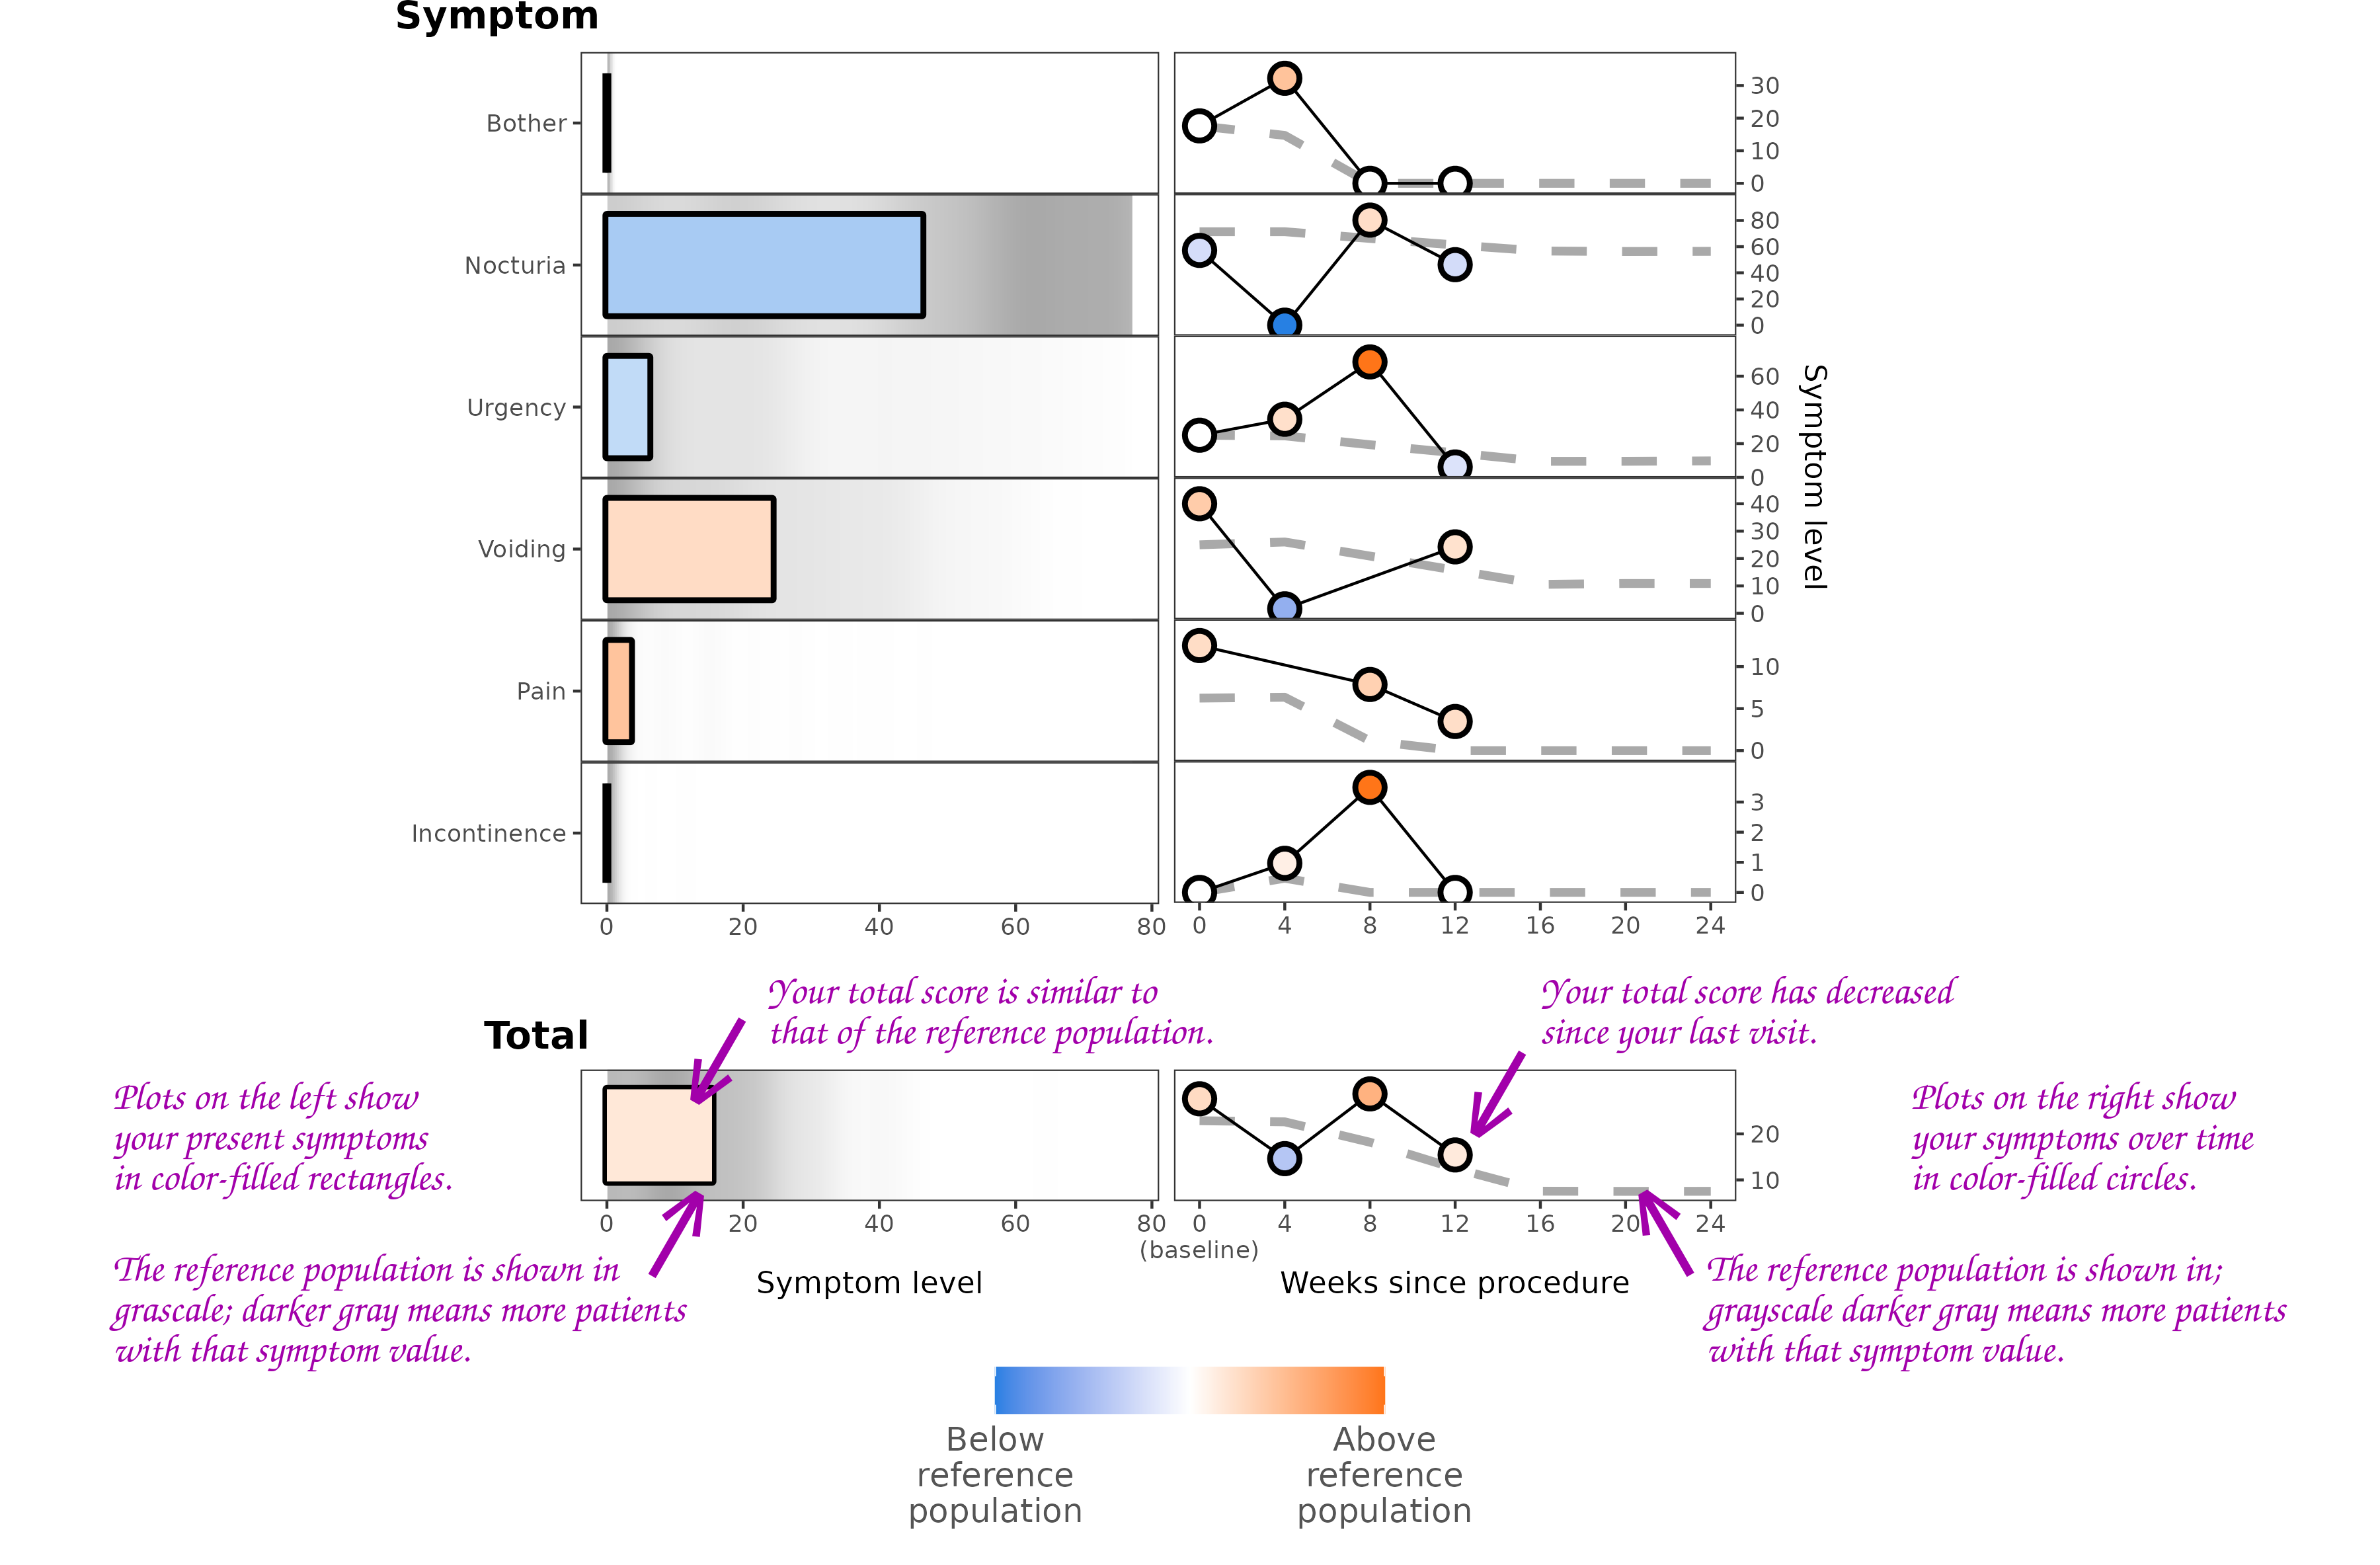

# A tibble: 1 × 7
  format width height colorspace matte filesize density  
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>    
1 PNG     3600   2367 sRGB       TRUE         0 +118x+118

In [137]:
create_current_week_summary_bar_chart <- function(){

    # create a summary for each of the columns for all patients as a comparison
    df <- select(syn_week_dat, -c(ID, Week))
    summary_df <- data.frame(
        Median = apply(df, 2, median, na.rm = TRUE),
        Percentile_16 = apply(df, 2, function(x) quantile(x, probs = 0.16, na.rm = TRUE)),
        Percentile_84 = apply(df, 2, function(x) quantile(x, probs = 0.84, na.rm = TRUE)),
        Percentile_25 = apply(df, 2, function(x) quantile(x, probs = 0.25, na.rm = TRUE)),
        Percentile_75 = apply(df, 2, function(x) quantile(x, probs = 0.75, na.rm = TRUE))
    )


    # add the symptoms in the correct order
    summary_df$Symptom <- factor(rownames(summary_df), levels = symptoms)

    # custom color palette
    custom_palette <- colorRamp(c("#2780E3", "white", "#ff7518"))

    # Function to get an interpolated color at a specific value
    get_interpolated_color <- function(value) {
        return(rgb(custom_palette(value), maxColorValue = 255))
    }

    # get the patient data for the bar chart
    df_patient <- select(syn_week_dat[input_params$patient_row, ], -c(ID, Week))
    p <- as.data.frame(t(df_patient))
    names(p) <- c('Value')

    # get the patient data for the bar chart
    # I wonder if there's a way to get the percentiles without a for loop?
    p$Percentile <- 0
    p$Color <- '#D3D3D3'
    for (s in symptoms){
        if (!is.nan(p[s,]$Value)){
            percentile <- ecdf(df[[s]])
            p[s,]$Percentile <- percentile(p[s,]$Value)
            # p[s,]$Color <- ifelse (p[s,]$Percentile > 0.25 &  p[s,]$Percentile < 0.27,  get_interpolated_color(p[s,]$Percentile), '#FFFFFF')
            p[s,]$Color <- get_interpolated_color(p[s,]$Percentile)
        }
    }
    summary_df$Value <- p$Value
    summary_df$Percentile <- p$Percentile
    summary_df$Color <- p$Color

    # for labelling (so that I can match the size of the other plot)
    breaks <- seq(0, 100, 20)
    labels <- c("0\n", "20", "40", "60", "80", "100")

    # get the maximum value to define the axis limits
    max_value <- max(unlist(summary_df[sapply(summary_df, is.numeric)]), na.rm = TRUE)

    main <- ggplot(summary_df[(summary_df$Symptom != "Total"),]) +
        stat_density(
            data = df_long[(df_long$Symptom != "Total"),],
            aes(x = Symptom, y = Value, fill = after_stat(scaled),),
            geom = "raster",
            position = "identity",
            bounds = c(0,100),
            show.legend = FALSE
        ) +
        scale_fill_gradient2(low = "white", high = "darkgray", limits = c(0., 1)) + 
        new_scale_fill() +
        # geom_rect(aes(x = Symptom, y = Median, xmin = 0.4, xmax = 1.6, ymin = Percentile_25, ymax = Percentile_75), stat = "identity", fill = "darkgray", size = 0.75) +
        # geom_errorbar(aes(x = Symptom, y = NULL, ymin = Median, ymax = Median), width = 1.2, color = "darkgray", size = 3) +
        geom_bar(
            aes(x = Symptom, y = Value), 
            stat = "identity", 
            fill = "white", 
            color = "black", 
            size = 1.5, 
            width = 0.7
        ) + 
        geom_bar(
            aes(x = Symptom, y = Value, fill = Color), 
            stat = "identity", 
            color = "black", 
            width = 0.7
        ) +
        scale_fill_identity() +   
        scale_x_discrete(expand = c(0,0)) +
        scale_y_continuous("", breaks = breaks, labels = labels, limits = c(0, max_value)) +
        facet_grid(Symptom ~ ., 
            scales = "free_y", 
            switch = "both"
        ) +
        coord_flip() +
        guides(fill = FALSE) +
        theme_bw() +
        xlab("") + 
        theme(
            panel.spacing = unit(0, "lines"),
            strip.text = element_text(size = 0, margin = margin(0,0,0,0)),
            plot.margin = margin(0.7, 0.09, 0.85, 5, "cm"),
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
         ) 

    total <- ggplot(summary_df[(summary_df$Symptom == "Total"),]) +
        stat_density(
            data = df_long[(df_long$Symptom == "Total"),],
            aes(x = Symptom, y = Value, fill = after_stat(scaled),),
            geom = "raster",
            position = "identity",
            bounds = c(0,100),
            show.legend = FALSE
        ) +
        scale_fill_gradient2(low = "white", high = "darkgray", limits = c(0., 1)) + 
        new_scale_fill() +
        # geom_rect(aes(x = Symptom, y = Median, xmin = 0.4, xmax = 1.6, ymin = Percentile_25, ymax = Percentile_75), stat = "identity", fill = "darkgray", size = 0.75) +
        # geom_errorbar(aes(x = Symptom, y = NULL, ymin = Median, ymax = Median), width = 1.2, color = "darkgray", size = 3) +
        geom_bar(
            aes(x = Symptom, y = Value), 
            stat = "identity", 
            fill = "white", 
            color = "black", 
            size = 1.5, 
            width = 0.7
        ) + 
        geom_bar(
            aes(x = Symptom, y = Value, fill = Color), 
            stat = "identity",
             width = 0.7
            ) +  
        scale_fill_identity() +   
        scale_x_discrete(breaks = "", labels = "", expand = c(0,0)) +
        scale_y_continuous("Symptom level", breaks = breaks, labels = labels, limits = c(0, max_value)) +
        facet_grid(Symptom ~ ., 
            scales = "free_y", 
            switch = "both"
        ) +
        coord_flip() +
        guides(fill = FALSE) +
        theme_bw() +
        xlab("") + 
        theme(
            strip.text = element_text(size = 0, margin = margin(0,0,0,0)),
            plot.margin = margin(0., 0.09, 0.25, 5, "cm"),
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
         ) 

    g <- plot_grid(main, total, 
        labels = c('Symptom', 'Total'), 
        rel_heights = c(length(symptoms) - 1, 1.4),
        label_y = c(1.01, 1.25),
        label_x = c(0.25,0.37),
        ncol = 1,
        align = "v",
        axis = "b"
    )


    return(g)
}

create_time_series_line_plot <- function(){

    # there may be a more streamlined way to do this, but I don't know it!
    median_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), median, na.rm = TRUE))
    median_values_t <- median_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Median")

    Q1_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), ~ quantile(., 0.16, na.rm = TRUE)))
    Q1_values_t <- Q1_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Q1")

    Q3_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), ~ quantile(., 0.84, na.rm = TRUE)))
    Q3_values_t <- Q3_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Q3")

    patient_data <- select(syn_long_dat[syn_long_dat$ID == input_params$patient_id, ], -ID)
    patient_data_t <- patient_data %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Value")

    merged_df <- merge(median_values_t, Q1_values_t, by = c("Week", "Symptom")) %>%
        merge(Q3_values_t, by = c("Week", "Symptom")) %>%
        merge(patient_data_t, by = c("Week", "Symptom"))
        

    # Add a row for the full 1sigma width
    merged_df$Width <- merged_df$Q3 - merged_df$Q1
    # what should I do with width == 0 ??!!
    merged_df$Width[merged_df$Width == 0] <- 1.

    # set the symptoms as a factor and in the correct order
    merged_df$Symptom <- factor(merged_df$Symptom, levels = symptoms)

    # omit the rows with nan values??
    merged_df_clean_limit_week <- na.omit(merged_df[merged_df$Week <= input_params$patient_week, ])

    # custom color palette
    custom_palette <- c("#2780E3", "white", "#ff7518")

    # for labelling
    breaks <- seq(0, 24, 4)
    labels <- c("0\n(baseline)", "4", "8", "12", "16", "20", "24")
    labels2 <- c("0", "4", "8", "12", "16", "20", "24")

    # function to calculate custom breaks
    custom_breaks <- function(data, n_breaks = 4, tol = 0.5) {
        # Calculate breaks based on data range
        min_value <- min(data)
        max_value <- max(data)
        breaks <- pretty(c(min_value, max_value), n = n_breaks)
        diff <- breaks[2] - breaks[1]
        top_diff <- max_value - breaks[length(breaks)]
        if (abs(top_diff/diff) > tol) {
            breaks <- breaks[1:(length(breaks) - 1)]
            if (top_diff < 0){
                breaks <- breaks[1:(length(breaks) - 1)]
            }
        }
        return(breaks)
    }

    main <- ggplot(merged_df[(merged_df$Symptom != "Total"),], aes(x = Week, y = Median)) +
        geom_line(color = "darkgray", linetype = "dashed", size = 1.5) +
        geom_line(data = merged_df_clean_limit_week[(merged_df_clean_limit_week$Symptom != "Total"),], aes(y = Value)) +
        geom_point(data = merged_df_clean_limit_week[(merged_df_clean_limit_week$Symptom != "Total"),], aes(y = Value, fill = (Value - Median)/Width), shape = 21, color = "black", size = 4, stroke = 1.5) + 
        scale_fill_gradient2(
            low = custom_palette[1], 
            mid = custom_palette[2], 
            high = custom_palette[3],
            midpoint = 0, 
            limits = c(-1, 1),
            oob = scales::squish
        ) +   
        facet_grid(Symptom ~ ., 
            scales = "free_y", 
            switch = "both",
        ) + 
        scale_x_continuous("", breaks = breaks, labels = labels2, limits = c(0, 24)) + 
        scale_y_continuous("Symptom level", expand = expansion(mult = c(0.1, 0.25)),
            breaks = function(x) {
                return(custom_breaks(x))
            },
            position = "right"
        ) +
        expand_limits(x = c(-1, 26)) + 
        ylab("") + 
        # theme_void() + 
        guides(fill = FALSE) +
        theme_bw() + 
        theme(
            panel.spacing = unit(0, "lines"),
            strip.text = element_text(size = 0, margin = margin(0,0,0,0)),
            plot.margin = margin(0.7, 7, 1.2, 0.1, "cm"),
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            axis.title.y.right = element_text(margin = margin(l = 10))
        )  

    total <- ggplot(merged_df[(merged_df$Symptom == "Total"),], aes(x = Week, y = Median)) +
        geom_line(color = "darkgray", linetype = "dashed", size = 1.5) +
        geom_line(data = merged_df_clean_limit_week[(merged_df_clean_limit_week$Symptom == "Total"),], aes(y = Value)) +
        geom_point(data = merged_df_clean_limit_week[(merged_df_clean_limit_week$Symptom == "Total"),], aes(y = Value, fill = (Value - Median)/Width), shape = 21, color = "black", size = 4, stroke = 1.5) + 
        scale_fill_gradient2(
            low = custom_palette[1], 
            mid = custom_palette[2], 
            high = custom_palette[3],
            midpoint = 0, 
            limits = c(-1, 1),
            oob = scales::squish
        ) +   
        facet_grid(Symptom ~ ., 
            scales = "free_y", 
            switch = "both",
        ) + 
        scale_x_continuous("Weeks since procedure", breaks = breaks, labels = labels, limits = c(0, 24)) + 
        scale_y_continuous("", expand = expansion(mult = c(0.1, 0.25)),
            breaks = function(x) {
                return(custom_breaks(x))
            },
            position = "right"
        ) +
        expand_limits(x = c(-1, 26)) + 
        ylab("") + 
        # theme_void() + 
        guides(fill = FALSE) +
        theme_bw() + 
        theme(
            strip.text = element_text(size = 0, margin = margin(0,0,0,0)),
            plot.margin = margin(0., 7, 0.25, 0.1, "cm"),
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            axis.title.y.right = element_text(margin = margin(l = 10))
        ) 

    g <- plot_grid(main, total, 
        rel_heights = c(length(symptoms) - 1, 1.4),
        ncol = 1,
        align = "v",
        axis = "b"
    )

    # create another plot just for the legend (not sure there's a simpler way to do this!)
    breaks <- c(-1, 1)
    labels <- c("Below\nreference\npopulation", "Above\nreference\npopulation")
    g_legend <- ggplot(merged_df, aes(x = Week, y = Median)) +
        geom_line(color = "darkgray", linetype = "dashed", size = 1.5) +
        geom_line(data = merged_df_clean_limit_week, aes(y = Value)) +
        geom_point(data = merged_df_clean_limit_week, aes(y = Value, fill = (Value - Median)/Width), shape = 21, color = "black", size = 4, stroke = 1.5) + 
        scale_fill_gradient2(
            low = custom_palette[1], 
            mid = custom_palette[2], 
            high = custom_palette[3],
            midpoint = 0, 
            limits = c(-1, 1),
            oob = scales::squish,
            breaks = breaks,
            labels = labels
        ) +    
         guides(
            fill = guide_colorbar(
                title = "",#Scaled offset from median of reference population",
                title.position = "bottom",
                title.hjust = 0.5,
                title.vjust = 0,
                label.position = "bottom"
            )
        ) + 
        theme_bw() + 
        theme(
            legend.position = "bottom",           
            legend.key.width = unit(1, "cm"),
            legend.title.align = 0.5,
            legend.margin = margin(margin(10,0,0,0,"cm")),
            legend.title = element_text(size = 9), 
            legend.text = element_text(size = 12, color = "#555555")
        )   


    legend <- cowplot::get_legend(g_legend)
    

    return(
        list(
            "plot" = g,
            "legend" = legend
        )
    )
}

annotate_img <- function(p, acolor){
    # save the image and then read it back in so that I can annotate it more easily!
    tmp <- tempfile("image0", fileext = ".png")
    ggsave(tmp, p, width = 12, height = 8)
    img <- image_read(tmp)  %>%
        # left plot label
        # image_annotate(sprintf('\u2191'), size = 200, color = acolor,
        #     boxcolor = "transparent", degrees = 90, location = "+780+1650") %>%
        image_annotate("Plots on the left show\nyour present symptoms\nin color-filled rectangles.", 
            size = 60, color = acolor, boxcolor = "transparent", degrees = 0, location = "+170+1640", font = 'Times') %>%
        # right plot label
        # image_annotate(sprintf('\u2191'), size = 200, color = acolor,
        #     boxcolor = "transparent", degrees = -90, location = "+2800+1800") %>%
        image_annotate("Plots on the right show\nyour symptoms over time\nin color-filled circles.", 
            size = 60, color = acolor, boxcolor = "transparent", degrees = 0, location = "+2890+1640", font = 'Times')  %>%
        # left plot reference (TODO - link x position to actual total reference value)
        image_annotate(sprintf('\u2191'), size = 200, color = acolor,
            boxcolor = "transparent", degrees = 30, location = "+960+1780")  %>%
        # image_annotate("Half of the reference population\nhave values inside the gray region", size = 60, color = acolor,
        #     boxcolor = "transparent", degrees = 0, location = "+300+1900", font = 'Times')  %>% 
        image_annotate("The reference population is shown in\ngrascale; darker gray means more patients\nwith that symptom value.", 
            size = 60, color = acolor,  boxcolor = "transparent", degrees = 0, location = "+170+1900", font = 'Times')  %>%        
        # right plot reference (TODO - link x position to actual total reference value)
        image_annotate(sprintf('\u2191'), size = 200, color = acolor,
            boxcolor = "transparent", degrees = -30, location = "+2460+1850")  %>%
        # image_annotate("Half of the reference population\nhave values inside the gray region", size = 60, color = acolor,
        #     boxcolor = "transparent", degrees = 0, location = "+2580+1900", font = 'Times')  %>%      
        image_annotate("The reference population is shown in;\ngrayscale darker gray means more patients\nwith that symptom value.", 
            size = 60, color = acolor, boxcolor = "transparent", degrees = 0, location = "+2580+1900", font = 'Times')  %>%   
        # left plot explanation (TODO - link x position to actual patient value and automatic text)
        image_annotate(sprintf('\u2191'), size = 200, color = acolor,
            boxcolor = "transparent", degrees = 210, location = "+1150+1700")  %>%
        image_annotate("Your total score is similar to\nthat of the reference population.", 
            size = 60, color = acolor, boxcolor = "transparent", degrees = 0, location = "+1160+1480", font = 'Times')  %>%
        # left plot explanation (TODO - link x position to actual patient value and automatic text)
        image_annotate(sprintf('\u2191'), size = 200, color = acolor,
            boxcolor = "transparent", degrees = 210, location = "+2330+1750")  %>%
        image_annotate("Your total score has decreased\nsince your last visit.", 
            size = 60, color = acolor, boxcolor = "transparent", degrees = 0, location = "+2330+1480", font = 'Times') 

    return(img) 
}

patient_id <- 100
patient_week <- 12
input_params <- list(
    patient_id = patient_id, 
    patient_week = patient_week, 
    patient_row = which(syn_week_dat$ID == patient_id)[1]
)

syn_week_dat$Bother <- rescale_to_range(syn_week_dat$Bother, 0, 100)
syn_long_dat$Bother <- rescale_to_range(syn_long_dat$Bother, 0, 100)

bar_chart <- create_current_week_summary_bar_chart()
line_plot <- create_time_series_line_plot()

g <- plot_grid(bar_chart, line_plot$plot, ncol = 2, align = "h", rel_widths = c(0.49,0.51), axis = "l")
p <- plot_grid(g, line_plot$legend, ncol = 1, rel_heights = c(1, 0.2))



img <- annotate_img(p, "#a200aa")
image_trim(img)



## time series on left

In [ ]:
create_current_week_summary_bar_chart <- function(){

    # create a summary for each of the columns for all patients as a comparison
    df <- select(syn_week_dat, -c(ID, Week))
    summary_df <- data.frame(
        Median = apply(df, 2, median, na.rm = TRUE),
        Percentile_16 = apply(df, 2, function(x) quantile(x, probs = 0.16, na.rm = TRUE)),
        Percentile_84 = apply(df, 2, function(x) quantile(x, probs = 0.84, na.rm = TRUE))
    )

    # Add a row for the full 1sigma width
    summary_df$Width <- summary_df$Percentile_84 - summary_df$Percentile_16

    # what should we do if width == 0??
    summary_df$Width[summary_df$Width == 0] <- 1.

    # add the symptoms in the correct order
    summary_df$Symptom <- factor(rownames(summary_df), levels = symptoms)

    # get the patient data for the bar chart
    df_patient <- select(syn_week_dat[input_params$patient_row, ], -c(ID, Week))
    p <- as.data.frame(t(df_patient))
    summary_df$Value <- p[, 1]

    # Define a custom color palette
    custom_palette <- c("#2780E3", "white", "#ff7518")

    # for labelling (so that I can match the size of the other plot)
    breaks <- seq(0, 100, 20)
    labels <- c("0\n", "20", "40", "60", "80", "100")

    # separate the Total
    panel_spacing <- rep(0, length(symptoms) - 1)
    panel_spacing[length(panel_spacing)] <- 1

    g <- ggplot(summary_df, aes(x = Symptom, y = Value, fill = (Value - Median)/Width)) +
        # scale_x_discrete(limits = rev(levels(summary_df$Symptom)), labels = rep("", length(symptoms))) +
        scale_y_continuous("Current Value", breaks = breaks, labels = labels, expand = expansion(mult = c(0, 0.05))) +
        geom_bar(stat = "identity", fill = "white", color = "black", size = 1.5) + 
        geom_bar(stat = "identity") + 
        scale_fill_gradient2(
            low = custom_palette[1], 
            mid = custom_palette[2], 
            high = custom_palette[3],
            midpoint = 0, 
            limits = c(-1,1),
            oob = scales::squish
        ) +    
        geom_errorbar(aes(y = NULL, ymin = Median, ymax = Median), width = 0.75, color = "darkgray", size = 3) +
        # geom_vline(xintercept = 1.5, linetype = "dotted") + 
        geom_vline(xintercept = 0.4) + 
        # geom_vline(xintercept = 1.6) + 
        facet_grid(Symptom ~ ., 
            scales = "free_y", 
            switch = "both",
        ) + 
        coord_flip() + 
        xlab("") + 
        guides(fill = FALSE) +
        theme_classic() +
        theme(
            plot.margin = margin(0.25, 0.25, 0.25, 0.1, "cm"),
            panel.spacing = unit(panel_spacing, "lines"),
            strip.text = element_text(size = 0, margin = margin(0,0,0,0)),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank()
        )


    return(g)
}

create_time_series_line_plot <- function(){

    # there may be a more streamlined way to do this, but I don't know it!
    median_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), median, na.rm = TRUE))
    median_values_t <- median_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Median")

    Q1_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), ~ quantile(., 0.16, na.rm = TRUE)))
    Q1_values_t <- Q1_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Q1")

    Q3_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), ~ quantile(., 0.84, na.rm = TRUE)))
    Q3_values_t <- Q3_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Q3")

    patient_data <- select(syn_long_dat[syn_long_dat$ID == input_params$patient_id, ], -ID)
    patient_data_t <- patient_data %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Value")

    merged_df <- merge(median_values_t, Q1_values_t, by = c("Week", "Symptom")) %>%
        merge(Q3_values_t, by = c("Week", "Symptom")) %>%
        merge(patient_data_t, by = c("Week", "Symptom"))
        

    # Add a row for the full 1sigma width
    merged_df$Width <- merged_df$Q3 - merged_df$Q1
    # what should I do with width == 0 ??!!
    merged_df$Width[merged_df$Width == 0] <- 1.

    # set the symptoms as a factor and in the correct order
    merged_df$Symptom <- factor(merged_df$Symptom, levels = symptoms)

    # omit the rows with nan values??
    merged_df_clean_limit_week <- na.omit(merged_df[merged_df$Week <= input_params$patient_week, ])

    # custom color palette
    custom_palette <- c("#2780E3", "white", "#ff7518")

    # for labelling
    breaks <- seq(0, 24, 4)
    labels <- c("0\n(baseline)", "4", "8", "12", "16", "20", "24")

    # separate the Total
    panel_spacing <- rep(0, length(symptoms) - 1)
    panel_spacing[length(panel_spacing)] <- 1

    # function to calculate custom breaks
    custom_breaks <- function(data, n_breaks = 4, tol = 0.5) {
        # Calculate breaks based on data range
        min_value <- min(data)
        max_value <- max(data)
        breaks <- pretty(c(min_value, max_value), n = n_breaks)
        diff <- breaks[2] - breaks[1]
        top_diff <- max_value - breaks[length(breaks)]
        if (abs(top_diff/diff) > tol) {
            breaks <- breaks[1:(length(breaks) - 1)]
            if (top_diff < 0){
                breaks <- breaks[1:(length(breaks) - 1)]
            }
        }
        return(breaks)
    }

    g <- ggplot(merged_df, aes(x = Week, y = Median)) +
        geom_line(color = "darkgray", linetype = "dashed", size = 1.5) +
        geom_line(data = merged_df_clean_limit_week, aes(y = Value)) +
        geom_point(data = merged_df_clean_limit_week, aes(y = Value, fill = (Value - Median)/Width), shape = 21, color = "black", size = 4, stroke = 1.5) + 
        scale_fill_gradient2(
            low = custom_palette[1], 
            mid = custom_palette[2], 
            high = custom_palette[3],
            midpoint = 0, 
            limits = c(-1, 1),
            oob = scales::squish
        ) +   
        geom_hline(yintercept = 0) + 
        facet_grid(Symptom ~ ., 
            scales = "free_y", 
            switch = "both",
        ) + 
        scale_x_continuous("Weeks since procedure", breaks = breaks, labels = labels) + 
        scale_y_continuous(expand = expansion(mult = c(0, 0.25)),
            breaks = function(x) {
                return(custom_breaks(x))
            },
        ) +
        expand_limits(x = c(-1, 26)) + 
        ylab("") + 
        guides(fill = FALSE) +
        theme_classic() + 
        theme(
            # strip.text = element_text(size = 0, margin = margin(0,0,0,0)),
            plot.margin = margin(0.25, 0, 0.25, 0.25, "cm"),
            panel.spacing = unit(panel_spacing, "lines")
        ) 

    # create another plot just for the legend (not sure there's a simpler way to do this!)
    g_legend <- ggplot(merged_df, aes(x = Week, y = Median)) +
        geom_line(color = "darkgray", linetype = "dashed", linewidth = 1.5) +
        geom_line(data = merged_df_clean_limit_week, aes(y = Value)) +
        geom_point(data = merged_df_clean_limit_week, aes(y = Value, fill = (Value - Median)/Width), shape = 21, color = "black", size = 4, stroke = 1.5) + 
        scale_fill_gradient2(
            low = custom_palette[1], 
            mid = custom_palette[2], 
            high = custom_palette[3],
            midpoint = 0, 
            limits = c(-1, 1),
            oob = scales::squish
        ) +    
         guides(
            fill = guide_colorbar(
                title = "Scaled offset from median of reference population",
                title.position = "bottom",
                title.hjust = 0.5,
                title.vjust = 0,
                label.position = "bottom"
            )
        ) + 
        theme_classic() + 
        theme(
            legend.position = "bottom",           
            legend.key.width = unit(2, "cm"),
            legend.title.align = 0.5,
            legend.margin = margin(margin(10,0,0,0,"cm")),
            legend.title = element_text(size = 9), 
            legend.text = element_text(size = 8, color = "#555555")
        )   


    legend <- cowplot::get_legend(g_legend)

    return(
        list(
            "plot" = g,
            "legend" = legend
        )
    )
}



patient_id <- 100
patient_week <- 16
input_params <- list(
    patient_id = patient_id, 
    patient_week = patient_week, 
    patient_row = which(syn_week_dat$ID == patient_id)[1]
)

syn_week_dat$Bother <- rescale_to_range(syn_week_dat$Bother, 0, 100)
syn_long_dat$Bother <- rescale_to_range(syn_long_dat$Bother, 0, 100)

bar_chart <- create_current_week_summary_bar_chart()
line_plot <- create_time_series_line_plot()

g <- plot_grid(line_plot$plot, bar_chart,  ncol = 2, align = "h", rel_widths = c(0.55,0.45), axis = "l")
plot_grid(g, line_plot$legend, ncol = 1, rel_heights = c(1, 0.2))


In [ ]:
    
    # there may be a more streamlined way to do this, but I don't know it!
    median_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), median, na.rm = TRUE))
    median_values_t <- median_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Median")

    Q1_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), ~ quantile(., 0.16, na.rm = TRUE)))
    Q1_values_t <- Q1_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Q1")

    Q3_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), ~ quantile(., 0.84, na.rm = TRUE)))
    Q3_values_t <- Q3_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Q3")

    patient_data <- select(syn_long_dat[syn_long_dat$ID == input_params$patient_id, ], -ID)
    patient_data_t <- patient_data %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Value")

    merged_df <- merge(median_values_t, Q1_values_t, by = c("Week", "Symptom")) %>%
        merge(Q3_values_t, by = c("Week", "Symptom")) %>%
        merge(patient_data_t, by = c("Week", "Symptom"))
        

    # Add a row for the full 1sigma width
    merged_df$Width <- merged_df$Q3 - merged_df$Q1
    # what should I do with width == 0 ??!!
    merged_df$Width[merged_df$Width == 0] <- 1.

    # set the symptoms as a factor and in the correct order
    merged_df$Symptom <- factor(merged_df$Symptom, levels = symptoms)

    # omit the rows with nan values??
    merged_df_clean_limit_week <- na.omit(merged_df[merged_df$Week <= input_params$patient_week, ])

    # custom color palette
    custom_palette <- c("#2780E3", "white", "#ff7518")

    # for labelling
    breaks <- seq(0, 24, 4)
    labels <- c("0\n(baseline)", "4", "8", "12", "16", "20", "24")
    labels2 <- c("0", "4", "8", "12", "16", "20", "24")

    # function to calculate custom breaks
    custom_breaks <- function(data, n_breaks = 4, tol = 0.5) {
        # Calculate breaks based on data range
        min_value <- min(data)
        max_value <- max(data)
        breaks <- pretty(c(min_value, max_value), n = n_breaks)
        diff <- breaks[2] - breaks[1]
        top_diff <- max_value - breaks[length(breaks)]
        if (abs(top_diff/diff) > tol) {
            breaks <- breaks[1:(length(breaks) - 1)]
            if (top_diff < 0){
                breaks <- breaks[1:(length(breaks) - 1)]
            }
        }
        return(breaks)
    }

    main <- ggplot(merged_df[(merged_df$Symptom != "Total"),], aes(x = Week, y = Median)) +
        geom_line(color = "darkgray", linetype = "dashed", size = 1.5) +
        geom_line(data = merged_df_clean_limit_week[(merged_df_clean_limit_week$Symptom != "Total"),], aes(y = Value)) +
        geom_point(data = merged_df_clean_limit_week[(merged_df_clean_limit_week$Symptom != "Total"),], aes(y = Value, fill = (Value - Median)/Width), shape = 21, color = "black", size = 4, stroke = 1.5) + 
        scale_fill_gradient2(
            low = custom_palette[1], 
            mid = custom_palette[2], 
            high = custom_palette[3],
            midpoint = 0, 
            limits = c(-1, 1),
            oob = scales::squish
        ) +   
        facet_grid(Symptom ~ ., 
            scales = "free_y", 
            switch = "both",
        ) + 
        scale_x_continuous("", breaks = breaks, labels = labels2) + 
        scale_y_continuous("Symptom level", expand = expansion(mult = c(0.1, 0.25)),
            breaks = function(x) {
                return(custom_breaks(x))
            },
            position = "right"
        ) +
        expand_limits(x = c(-1, 26)) + 
        ylab("") + 
        # theme_void() + 
        guides(fill = FALSE) +
        theme_bw() + 
        theme(
            strip.text = element_text(size = 0, margin = margin(0,0,0,0)),
            plot.margin = margin(0.7, 0.25, 0.25, 0.1, "cm"),
            panel.spacing = unit(0, "lines"),
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            axis.title.y.right = element_text(margin = margin(l = 10))

        )  

    total <- ggplot(merged_df[(merged_df$Symptom == "Total"),], aes(x = Week, y = Median)) +
        geom_line(color = "darkgray", linetype = "dashed", size = 1.5) +
        geom_line(data = merged_df_clean_limit_week[(merged_df_clean_limit_week$Symptom == "Total"),], aes(y = Value)) +
        geom_point(data = merged_df_clean_limit_week[(merged_df_clean_limit_week$Symptom == "Total"),], aes(y = Value, fill = (Value - Median)/Width), shape = 21, color = "black", size = 4, stroke = 1.5) + 
        scale_fill_gradient2(
            low = custom_palette[1], 
            mid = custom_palette[2], 
            high = custom_palette[3],
            midpoint = 0, 
            limits = c(-1, 1),
            oob = scales::squish
        ) +   
        facet_grid(Symptom ~ ., 
            scales = "free_y", 
            switch = "both",
        ) + 
        scale_x_continuous("Weeks since procedure", breaks = breaks, labels = labels) + 
        scale_y_continuous("", expand = expansion(mult = c(0.1, 0.25)),
            breaks = function(x) {
                return(custom_breaks(x))
            },
            position = "right"
        ) +
        expand_limits(x = c(-1, 26)) + 
        ylab("") + 
        # theme_void() + 
        guides(fill = FALSE) +
        theme_bw() + 
        theme(
            strip.text = element_text(size = 0, margin = margin(0,0,0,0)),
            plot.margin = margin(0., 0.25, 0.25, 0.1, "cm"),
            panel.spacing = unit(0, "lines"),
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            axis.title.y.right = element_text(margin = margin(l = 10))

        )  
plot_grid(main, total, 
    rel_heights = c(length(symptoms) - 1, 1.6),
    ncol = 1,
    align = "v",
    axis = "b"
)


In [ ]:

merged_df_clean_limit_week[!(merged_df_clean_limit_week$Symptom == "Total"),]

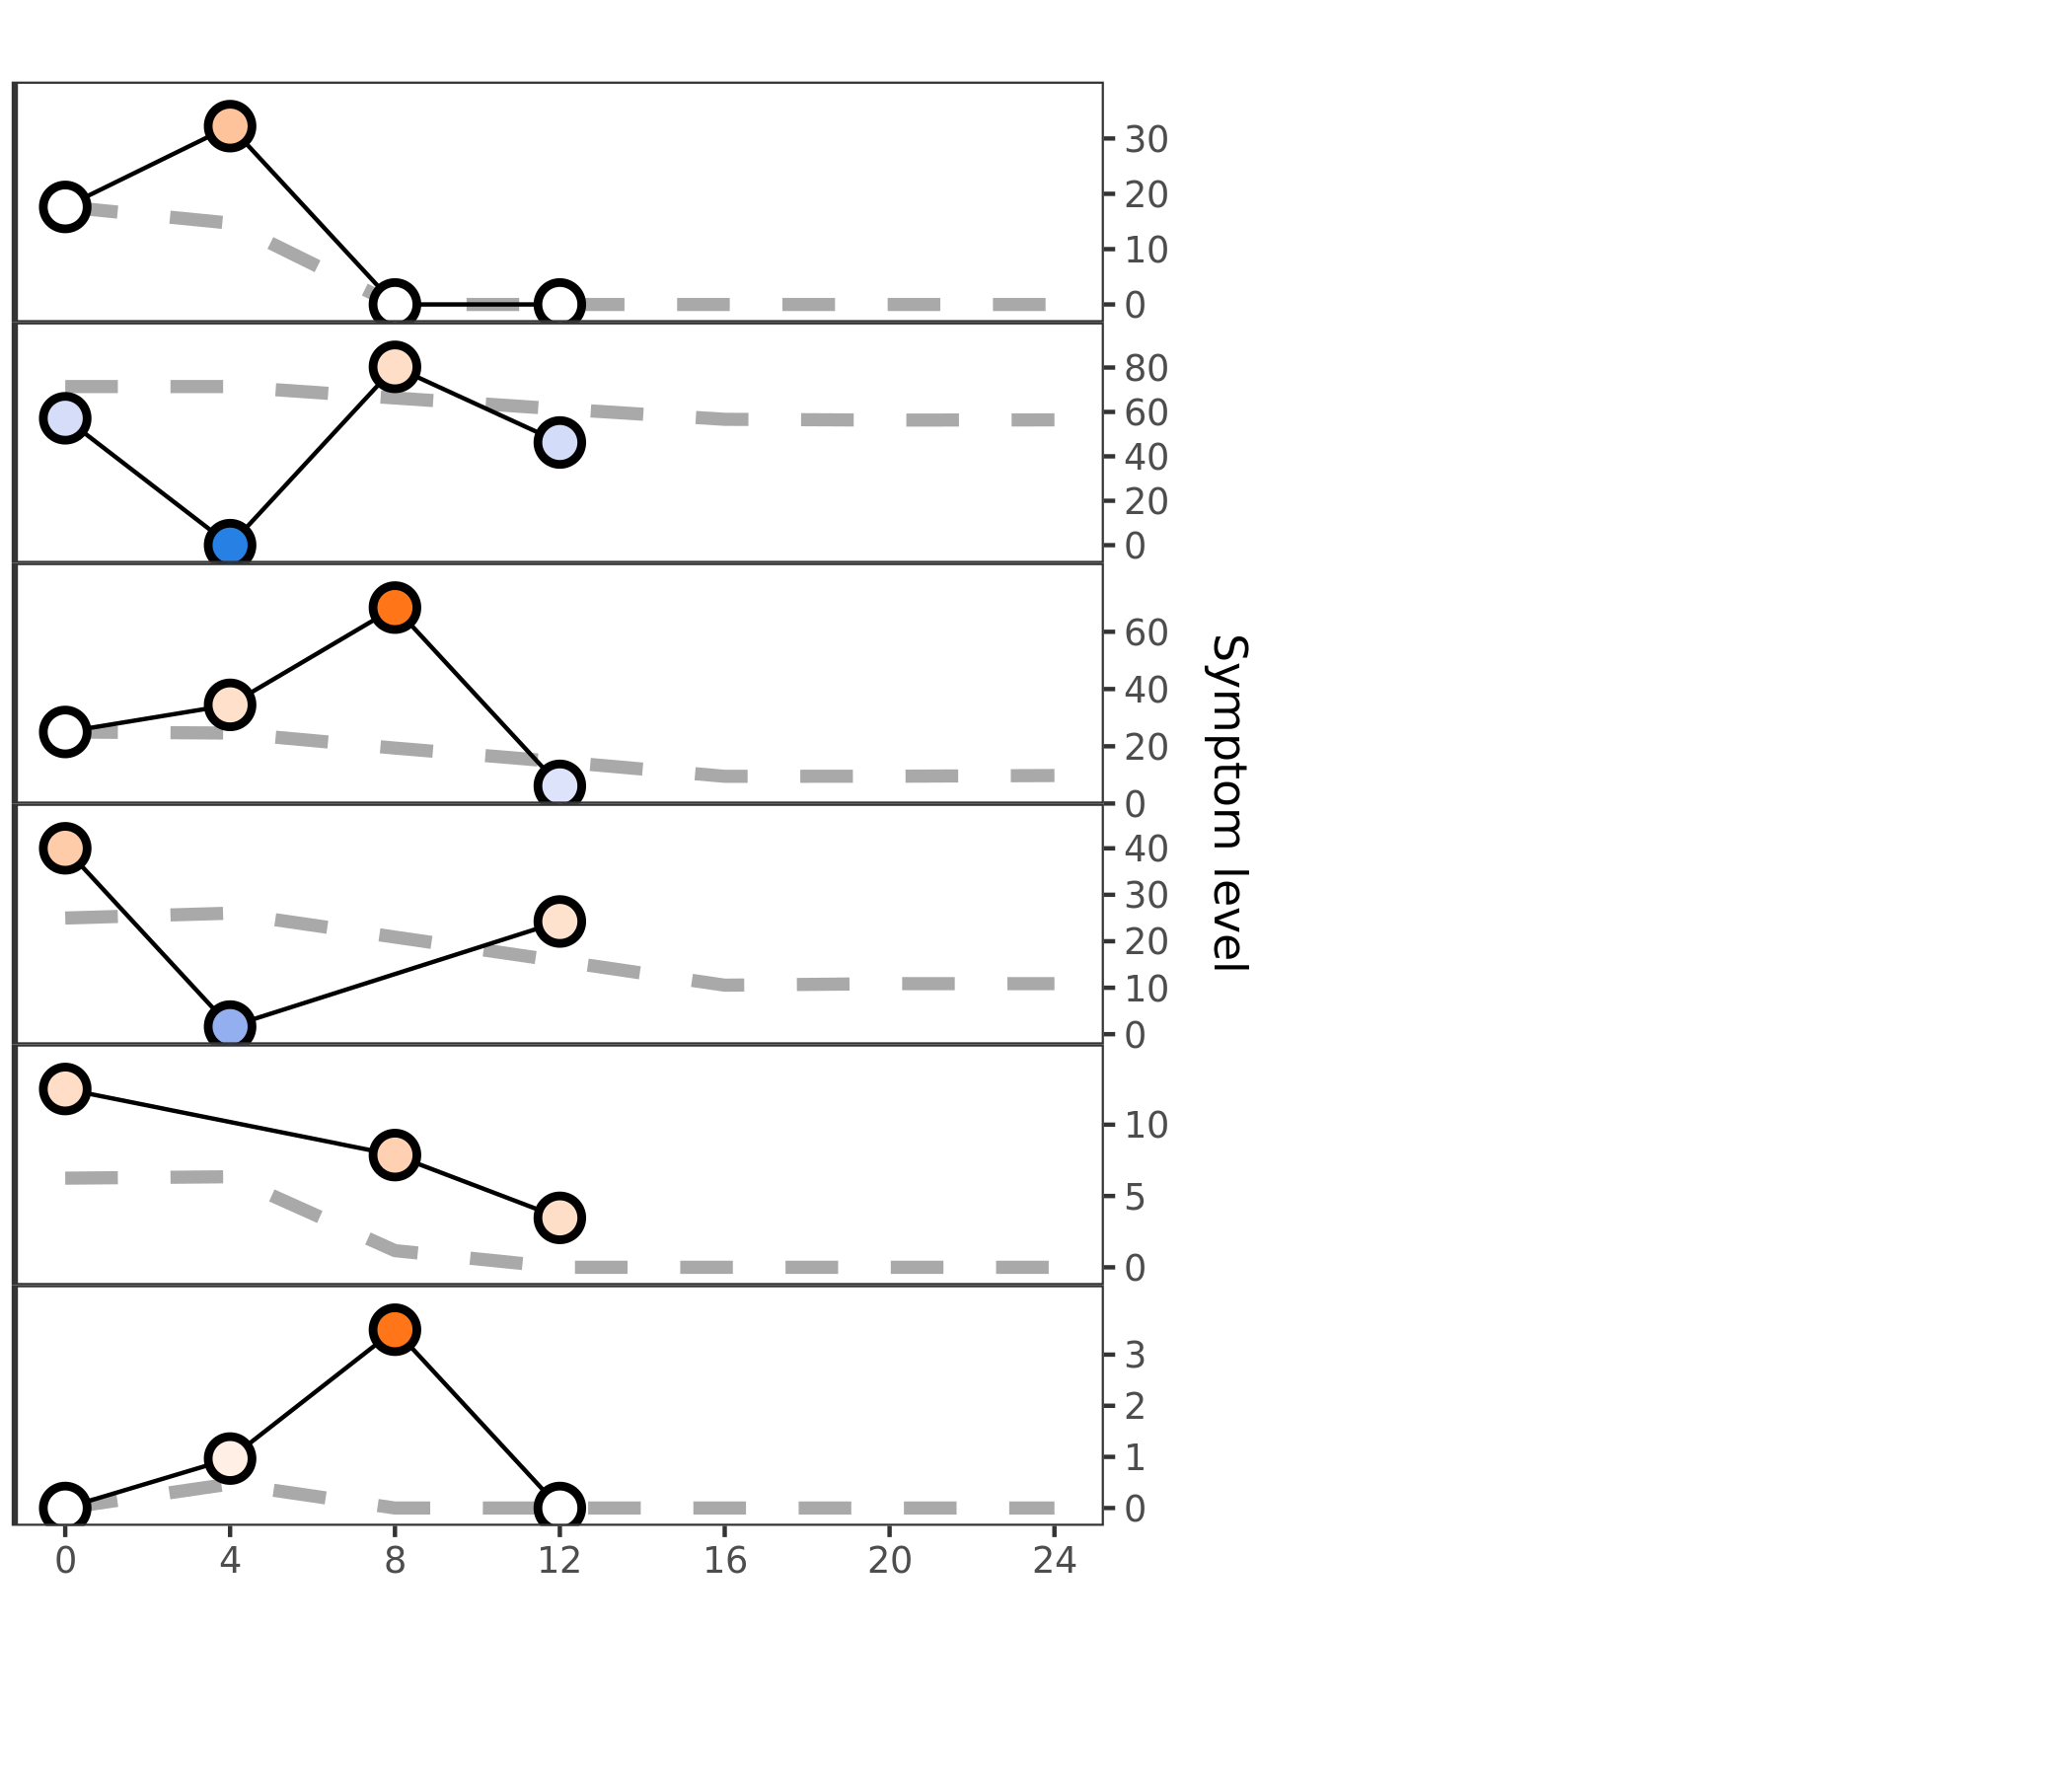

In [138]:
    # there may be a more streamlined way to do this, but I don't know it!
    median_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), median, na.rm = TRUE))
    median_values_t <- median_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Median")

    Q1_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), ~ quantile(., 0.16, na.rm = TRUE)))
    Q1_values_t <- Q1_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Q1")

    Q3_values <- syn_long_dat %>%
        group_by(Week) %>%
        summarize(across(-c(ID), ~ quantile(., 0.84, na.rm = TRUE)))
    Q3_values_t <- Q3_values %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Q3")

    patient_data <- select(syn_long_dat[syn_long_dat$ID == input_params$patient_id, ], -ID)
    patient_data_t <- patient_data %>%
        pivot_longer(cols = -c(Week),
            names_to = "Symptom",
            values_to = "Value")

    merged_df <- merge(median_values_t, Q1_values_t, by = c("Week", "Symptom")) %>%
        merge(Q3_values_t, by = c("Week", "Symptom")) %>%
        merge(patient_data_t, by = c("Week", "Symptom"))
        

    # Add a row for the full 1sigma width
    merged_df$Width <- merged_df$Q3 - merged_df$Q1
    # what should I do with width == 0 ??!!
    merged_df$Width[merged_df$Width == 0] <- 1.

    # set the symptoms as a factor and in the correct order
    merged_df$Symptom <- factor(merged_df$Symptom, levels = symptoms)

    # omit the rows with nan values??
    merged_df_clean_limit_week <- na.omit(merged_df[merged_df$Week <= input_params$patient_week, ])

    # custom color palette
    custom_palette <- c("#2780E3", "white", "#ff7518")

    # for labelling
    breaks <- seq(0, 24, 4)
    labels <- c("0\n(baseline)", "4", "8", "12", "16", "20", "24")
    labels2 <- c("0", "4", "8", "12", "16", "20", "24")

    # function to calculate custom breaks
    custom_breaks <- function(data, n_breaks = 4, tol = 0.5) {
        # Calculate breaks based on data range
        min_value <- min(data)
        max_value <- max(data)
        breaks <- pretty(c(min_value, max_value), n = n_breaks)
        diff <- breaks[2] - breaks[1]
        top_diff <- max_value - breaks[length(breaks)]
        if (abs(top_diff/diff) > tol) {
            breaks <- breaks[1:(length(breaks) - 1)]
            if (top_diff < 0){
                breaks <- breaks[1:(length(breaks) - 1)]
            }
        }
        return(breaks)
    }

    main <- ggplot(merged_df[(merged_df$Symptom != "Total"),], aes(x = Week, y = Median)) +
        geom_line(color = "darkgray", linetype = "dashed", size = 1.5) +
        geom_line(data = merged_df_clean_limit_week[(merged_df_clean_limit_week$Symptom != "Total"),], aes(y = Value)) +
        geom_point(data = merged_df_clean_limit_week[(merged_df_clean_limit_week$Symptom != "Total"),], aes(y = Value, fill = (Value - Median)/Width), shape = 21, color = "black", size = 4, stroke = 1.5) + 
        scale_fill_gradient2(
            low = custom_palette[1], 
            mid = custom_palette[2], 
            high = custom_palette[3],
            midpoint = 0, 
            limits = c(-1, 1),
            oob = scales::squish
        ) +   
        facet_grid(Symptom ~ ., 
            scales = "free_y", 
            switch = "both",
        ) + 
        scale_x_continuous("", breaks = breaks, labels = labels2, limits = c(0, 24)) + 
        scale_y_continuous("Symptom level", expand = expansion(mult = c(0.1, 0.25)),
            breaks = function(x) {
                return(custom_breaks(x))
            },
            position = "right"
        ) +
        expand_limits(x = c(-1, 26)) + 
        ylab("") + 
        # theme_void() + 
        guides(fill = FALSE) +
        theme_bw() + 
        theme(
            panel.spacing = unit(0, "lines"),
            strip.text = element_text(size = 0, margin = margin(0,0,0,0)),
            plot.margin = margin(0.7, 7, 1.2, 0.1, "cm"),
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            axis.title.y.right = element_text(margin = margin(l = 10))
        )  
main

In [119]:
summary_df[summary_df$Symptom != "Total",]

,Median,Percentile_16,Percentile_84,Percentile_25,Percentile_75,Symptom,Value,Percentile,Color
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>
Bother,0.00000,0.00000000,0.00000,0.000000,0.000000,Bother,NaN,0.0000000,#D3D3D3
Nocturia,61.32775,19.22189002,77.20456,33.610719,75.687766,Nocturia,46.239081,0.2991632,#A8CBF3
Urgency,14.57590,0.00000000,40.64757,0.000000,24.989763,Urgency,6.160912,0.3586066,#C1DBF7
Voiding,15.73506,0.02386687,39.97871,4.860106,31.849492,Voiding,24.255830,0.6247423,#FFDCC5
Pain,0.00000,0.00000000,14.50969,0.000000,7.894985,Pain,3.465808,0.7116183,#FFC49D
Incontinence,0.00000,0.00000000,0.00000,0.000000,0.000000,Incontinence,0.000000,0.9233954,#FF8A3B


In [180]:
# Define your custom colors and corresponding values
custom_palette <- colorRamp(c("#2780E3", "white", "#ff7518"))

# Function to get an interpolated color at a specific value
get_interpolated_color <- function(value) {
    return(rgb(custom_palette(value), maxColorValue = 255))
}

# Get an interpolated color at a specific value (e.g., 33)
value_to_interpolate <- 0.2
interpolated_color <- get_interpolated_color(value_to_interpolate)
print(interpolated_color)

[1] "#7DB2EE"


In [177]:
colorRamp(custom_palette)(0.3)

168.6,204.2,243.8


In [123]:
library(ggnewscale)